### Long-Short Divident Payer Portfolio

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import duckdb

data_path = '../Mikey_data'
if os.path.exists(data_path):
    os.chdir(data_path)
    print(f'Change directory to data path: {data_path}')
else:
    print('Please point to the correct data path!')

Change directory to data path: ../Mikey_data


In [2]:
# loading data

# standard CRSP exchange codes:
# 1 = NYSE
# 2 = AMEX
# 3 = NASDAQ
# 4 = NYSE Arca (includes SPY)
# 11 = NYSE MKT

con = duckdb.connect()

start_date = '2000-01-01'
end_date = '2014-01-01'

# Query:
# 1. join with delisting adjusted data
# 2. join with market data
# 3. filter by exchange
# 4. make sure the return is not null
query_data = (f"""
    SELECT 
    dsf.permno,
    dlycaldt  AS date,
    dlyret    AS ret,
    dlyorddivamt as div_amount,
    shrout    AS shares_outstanding,
    (shrout * dlyprc) AS market_cap,
    FROM read_parquet('crsp_202401.dsf_v2.parquet') AS dsf 
    JOIN (
        SELECT DISTINCT permno, hexcd AS exchange
        FROM read_parquet('crsp_202401.dsenames.parquet')
    ) AS exchanges
    ON dsf.permno = exchanges.permno
    WHERE dlycaldt BETWEEN '{start_date}' AND '{end_date}'
    AND exchange IN (1, 2, 3)
    AND dsf.dlyret IS NOT NULL
""")

crsp_df = con.execute(query_data).fetch_df()
crsp_df['date'] = pd.to_datetime(crsp_df['date'])
crsp_df = crsp_df.sort_values(['permno', 'date'])
crsp_df = crsp_df.reset_index(drop=True)
con.close()
crsp_df

,permno,date,ret,div_amount,shares_outstanding,market_cap
0,10001,2000-01-03,0.007353,0.0,2450,2.097812e+04
1,10001,2000-01-04,-0.014599,0.0,2450,2.067188e+04
2,10001,2000-01-05,0.014815,0.0,2450,2.097812e+04
3,10001,2000-01-06,-0.007299,0.0,2450,2.082500e+04
4,10001,2000-01-07,-0.007353,0.0,2450,2.067188e+04
...,...,...,...,...,...,...
22831212,93436,2013-12-24,0.054754,0.0,122594,1.856196e+07
22831213,93436,2013-12-26,0.027013,0.0,122594,1.906337e+07
22831214,93436,2013-12-27,-0.028167,0.0,122594,1.852641e+07
22831215,93436,2013-12-30,0.008735,0.0,122594,1.868823e+07


In [3]:
# Helper function to turn of the month identification
# Identify Trading Days Relative to Month End
# label trading days relative to month end
def label_trading_days(df):
    df = df.sort_values(['permno', 'date'])
    
    dates_labled = []
    
    dates_df = df.drop_duplicates(subset=['date'])[['date']].copy()
    dates_df['month'] = dates_df['date'].dt.to_period('M')

    # Initialize trading day labels
    dates_df['period_label'] = np.nan
    dates_df['period_label'] = dates_df['period_label'].astype(str)

    for month in tqdm(dates_df['month'].unique()):
        month_data = dates_df[dates_df['month'] == month]
        month_data.reset_index(drop=True, inplace=True)

        # handle corner cases: month data length not enough, cannot determine the trading day labels
        if len(month_data) < 10:
            continue
        # get around corner cases, where we don't have previous 8 days or next 8 days
        try:
            # start-of-month index in current month
            S_idx: int = month_data['date'].idxmin()
            # order matters, process 'T+1_T+4' first
            month_data.loc[list(range(S_idx, S_idx + 3)), 'period_label'] = 'T+1_T+3'
            month_data.loc[list(range(S_idx + 3, S_idx + 8)), 'period_label'] = 'T+4_T+8'
        except:
            pass

        try:
            # end-of-month index in current month
            T_idx: int = month_data['date'].idxmax()
            month_data.loc[T_idx, 'period_label'] = 'T'
            # order matters for the same reason
            month_data.loc[list(range(T_idx - 3, T_idx)), 'period_label'] = 'T-3_T-1'
            month_data.loc[list(range(T_idx - 8, T_idx - 3)), 'period_label'] = 'T-8_T-4'
        except:
            pass
            
        dates_labled.append(month_data)
            
    dates_labled_df = pd.concat(dates_labled, ignore_index=True)

    result_df = pd.merge(df, dates_labled_df[['date', 'period_label']], on='date', how='left')
    
    return result_df

In [4]:
crsp_df = label_trading_days(crsp_df)

100%|██████████| 168/168 [00:00<00:00, 682.19it/s]


In [5]:
crsp_df[crsp_df['permno'] == 10009].sort_values('date')

,permno,date,ret,div_amount,shares_outstanding,market_cap,period_label
6823,10009,2000-01-03,0.135593,0.0,2307,38642.2500,T+1_T+3
6824,10009,2000-01-04,-0.134328,0.0,2307,33451.5000,T+1_T+3
6825,10009,2000-01-05,0.075431,0.0,2307,35974.8966,T+1_T+3
6826,10009,2000-01-06,-0.046092,0.0,2307,34316.6250,T+4_T+8
6827,10009,2000-01-07,0.025210,0.0,2307,35181.7500,T+4_T+8
...,...,...,...,...,...,...,...
7033,10009,2000-10-31,-0.013980,0.0,2307,76275.1875,T
7034,10009,2000-11-01,0.000000,0.0,2307,76275.1875,T+1_T+3
7035,10009,2000-11-02,0.001890,0.0,2307,76419.3750,T+1_T+3
7036,10009,2000-11-03,0.000000,0.0,2307,76419.3750,T+1_T+3


In [6]:
# which stocks pays monthly dividends?
con = duckdb.connect()
con.execute(f"""
    SELECT permno, COUNT(*) AS num_dividends
    FROM crsp_df
    WHERE div_amount > 0.00001
    GROUP BY permno
    ORDER BY permno
""").fetch_df()

,permno,num_dividends
0,10001,95
1,10002,38
2,10009,3
3,10026,37
4,10037,18
...,...,...
6120,93415,14
6121,93416,14
6122,93419,14
6123,93422,14


Now we want to create a new column in the dataframe: 'div_lag'. What this column does is that it will look back 1-year time window, and find the most recent dividend payment amount. If there is no dividend payment in the past year, then the value is 0

In [7]:
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd

# Calculate div_lag
def calculate_div_lag(group):
    group['div_lag'] = group['div_amount'].shift().rolling(window=252, min_periods=1).apply(lambda x: x[x != 0].max() if not x[x != 0].empty else 0)
    group['div_lag'] = group['div_lag'].fillna(0)
    return group

# Function to apply calculate_div_lag to each group
def process_group(name, group):
    return calculate_div_lag(group)

# Split the DataFrame by 'permno' and process each group in parallel
permno_groups = list(crsp_df.groupby('permno'))
results = Parallel(n_jobs=-1)(delayed(process_group)(name, group) for name, group in tqdm(permno_groups, desc="Calculating div_lag"))

# Combine the results back into a single DataFrame
crsp_df = pd.concat(results).reset_index(drop=True)

Calculating div_lag: 100%|██████████| 13476/13476 [02:18<00:00, 97.09it/s] 


,permno,date,div_amount,div_lag
0,10001,2000-01-03,0.0,0.0
1,10001,2000-01-04,0.0,0.0
2,10001,2000-01-05,0.0,0.0
3,10001,2000-01-06,0.0,0.0
4,10001,2000-01-07,0.0,0.0
...,...,...,...,...
22831212,93436,2013-12-24,0.0,0.0
22831213,93436,2013-12-26,0.0,0.0
22831214,93436,2013-12-27,0.0,0.0
22831215,93436,2013-12-30,0.0,0.0


In [ ]:
crsp_df.to_parquet('crsp_div_lag.parquet')

#### Apply Analysis

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import duckdb

data_path = '../Mikey_data'
if os.path.exists(data_path):
    os.chdir(data_path)
    print(f'Change directory to data path: {data_path}')
else:
    print('Please point to the correct data path!')

Change directory to data path: ../Mikey_data


In [2]:
crsp_df = pd.read_parquet('crsp_div_lag.parquet')
crsp_df

,permno,date,ret,div_amount,shares_outstanding,market_cap,period_label,div_lag
0,10001,2000-01-03,0.007353,0.0,2450,2.097812e+04,T+1_T+3,0.0
1,10001,2000-01-04,-0.014599,0.0,2450,2.067188e+04,T+1_T+3,0.0
2,10001,2000-01-05,0.014815,0.0,2450,2.097812e+04,T+1_T+3,0.0
3,10001,2000-01-06,-0.007299,0.0,2450,2.082500e+04,T+4_T+8,0.0
4,10001,2000-01-07,-0.007353,0.0,2450,2.067188e+04,T+4_T+8,0.0
...,...,...,...,...,...,...,...,...
22831212,93436,2013-12-24,0.054754,0.0,122594,1.856196e+07,T-8_T-4,0.0
22831213,93436,2013-12-26,0.027013,0.0,122594,1.906337e+07,T-3_T-1,0.0
22831214,93436,2013-12-27,-0.028167,0.0,122594,1.852641e+07,T-3_T-1,0.0
22831215,93436,2013-12-30,0.008735,0.0,122594,1.868823e+07,T-3_T-1,0.0


In [3]:
# lag the market cap, using market cap value of the previous month last trading day
con = duckdb.connect()
con.execute(
"""
  WITH month_end AS (
    SELECT permno, LAST_DAY(LAST(date)) AS month_end_date,
    LAST(market_cap) AS mcap_lag
    FROM crsp_df
    WHERE period_label IS NOT NULL
    AND market_cap IS NOT NULL
    GROUP BY permno, EXTRACT(YEAR FROM date), EXTRACT(MONTH FROM date)
  )
  SELECT crsp_df.*, month_end.mcap_lag as mcap_lag
  FROM crsp_df LEFT JOIN month_end
  ON crsp_df.permno = month_end.permno
  AND month_end.month_end_date = LAST_DAY(crsp_df.date - INTERVAL 1 MONTH)
  WHERE period_label IS NOT NULL
  AND period_label NOT LIKE '%nan%'
"""
)
crsp_df = con.fetch_df()
con.close()
crsp_df

,permno,date,ret,div_amount,shares_outstanding,market_cap,period_label,div_lag,mcap_lag
0,30940,2010-01-19,0.002578,0.0,55849,5863586.51,T-8_T-4,0.27,5279405.97
1,30940,2010-01-20,-0.011811,0.0,55849,5794333.75,T-8_T-4,0.27,5279405.97
2,30940,2010-01-21,-0.030169,0.0,55849,5619526.38,T-8_T-4,0.27,5279405.97
3,30940,2010-01-22,-0.005963,0.0,55849,5586016.98,T-8_T-4,0.27,5279405.97
4,30940,2010-01-25,-0.021296,0.0,55849,5467058.61,T-8_T-4,0.27,5279405.97
...,...,...,...,...,...,...,...,...,...
18507813,92270,2007-09-28,-0.017199,0.0,6400,128000.00,T,0.00,NaN
18507814,92271,2007-09-27,-0.007426,0.0,8750,175437.50,T-3_T-1,0.00,NaN
18507815,92271,2007-09-28,0.017456,0.0,8750,178500.00,T,0.00,NaN
18507816,92272,2007-09-27,-0.006070,0.0,8125,159656.25,T-3_T-1,0.00,NaN


In [4]:
# Helper function from Alan
def apply_quantiles(df, col, bins=10):
    """
    Assigns a quantile-based bin (1,...,bins) for each value in `col`
    within each date group.
    """
    def quantile_bin(s):
        # Use pd.qcut to get quantile bins; if duplicate edges occur, use rank instead.
        try:
            return pd.qcut(s, q=bins, labels=False, duplicates="drop") + 1
        except Exception:
            return np.ceil(s.rank(method='average') / len(s) * bins)
    return df.groupby('date')[col].transform(quantile_bin)

In [15]:
from tqdm import tqdm

def apply_group_quantiles(group, col, bins=10):
    group['bin'] = apply_quantiles(group, col, bins=bins)
    return group

crsp_df['month'] = crsp_df['date'].dt.to_period('M')
tqdm.pandas(desc="Applying quantiles")

# want to assign quantiles within each month
crsp_df = crsp_df.groupby('month').progress_apply(lambda group: apply_group_quantiles(group, 'div_lag', bins=10)).reset_index(drop=True)

Applying quantiles: 100%|██████████| 168/168 [00:12<00:00, 12.95it/s]


In [16]:
crsp_df

,permno,date,ret,div_amount,shares_outstanding,market_cap,period_label,div_lag,mcap_lag,month,bin
0,43861,2000-01-03,-0.080645,0.0,1823,25977.7500,T+1_T+3,0.00,NaN,2000-01,NaN
1,43861,2000-01-04,0.008772,0.0,1823,26205.6250,T+1_T+3,0.00,NaN,2000-01,1.0
2,43861,2000-01-05,0.026087,0.0,1823,26889.2500,T+1_T+3,0.00,NaN,2000-01,1.0
3,43861,2000-01-06,0.021186,0.0,1823,27458.9375,T+4_T+8,0.00,NaN,2000-01,1.0
4,43861,2000-01-07,0.029046,0.0,1823,28256.5000,T+4_T+8,0.00,NaN,2000-01,1.0
...,...,...,...,...,...,...,...,...,...,...,...
18507813,92271,2013-12-24,0.012903,0.0,9647,121166.3200,T-8_T-4,0.32,120973.38,2013-12,5.0
18507814,92271,2013-12-26,0.009554,0.0,9647,122323.9600,T-3_T-1,0.32,120973.38,2013-12,5.0
18507815,92271,2013-12-27,-0.001577,0.0,9647,122131.0200,T-3_T-1,0.32,120973.38,2013-12,5.0
18507816,92271,2013-12-30,-0.016588,0.0,9647,120105.1500,T-3_T-1,0.32,120973.38,2013-12,5.0


In [17]:
bins = crsp_df.groupby(['period_label', 'month', 'bin']).apply(
    lambda g: pd.Series({
        'EW': g['ret'].mean(),
        'VW': (g['ret'] * g['mcap_lag']).sum() / g['mcap_lag'].sum()
    })
).reset_index().groupby(['period_label', 'bin']).apply(
    lambda g: pd.Series({
        'EW': g['EW'].mean(),
        'VW': g['VW'].mean()
    })
).reset_index()

bins

/tmp/ipykernel_3034258/878005718.py:4: RuntimeWarning: invalid value encountered in scalar divide
  'VW': (g['ret'] * g['mcap_lag']).sum() / g['mcap_lag'].sum()
/tmp/ipykernel_3034258/878005718.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bins = crsp_df.groupby(['period_label', 'month', 'bin']).apply(
/tmp/ipykernel_3034258/878005718.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).reset_index()

,period_label,bin,EW,VW
0,T,1.0,0.004064,0.001201
1,T,2.0,0.002067,0.000571
2,T,3.0,0.001807,0.000628
3,T,4.0,0.001470,0.000495
4,T,5.0,0.002090,0.000536
5,T,6.0,0.001420,0.000574
6,T+1_T+3,1.0,0.001210,0.001167
7,T+1_T+3,2.0,0.000945,0.000808
8,T+1_T+3,3.0,0.000926,0.000978
9,T+1_T+3,4.0,0.000876,0.000844


In [18]:
# why specified bins=10 only gave 6 bins?
crsp_df.groupby(['period_label']).apply(
  lambda g: pd.Series({
    'percent_zero_div': (g['div_lag'] == 0).sum() / len(g) * 100,
  })
).reset_index().round({'percent_zero_div': 2})

/tmp/ipykernel_3034258/1036799506.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  crsp_df.groupby(['period_label']).apply(


,period_label,percent_zero_div
0,T,54.96
1,T+1_T+3,55.33
2,T+4_T+8,55.26
3,T-3_T-1,55.03
4,T-8_T-4,55.10


<Figure size 1000x600 with 0 Axes>

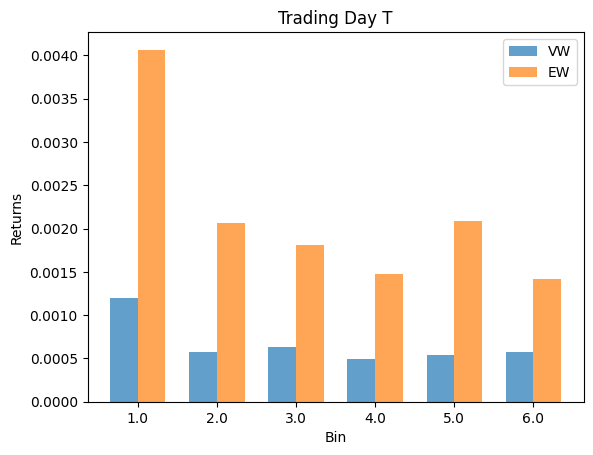

<Figure size 1000x600 with 0 Axes>

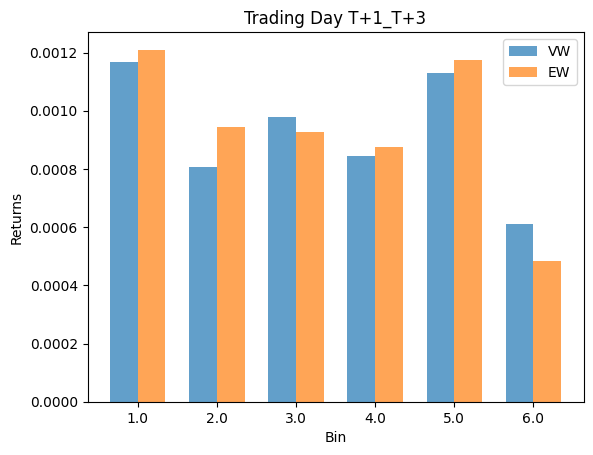

<Figure size 1000x600 with 0 Axes>

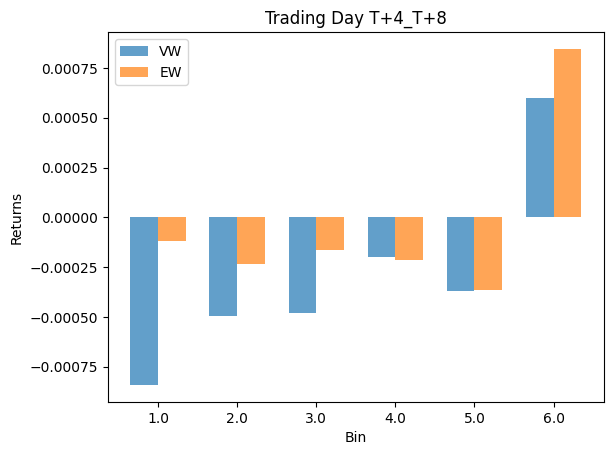

<Figure size 1000x600 with 0 Axes>

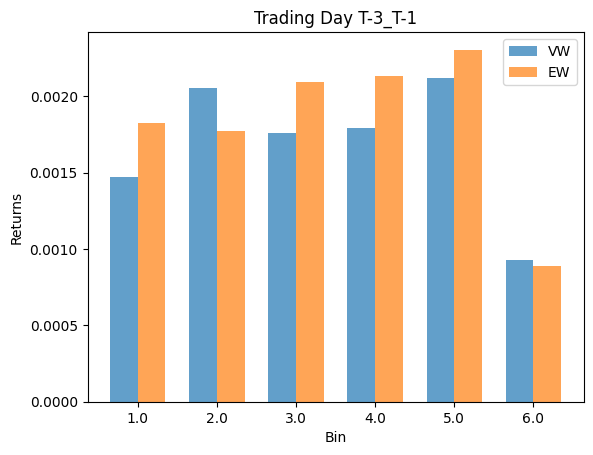

<Figure size 1000x600 with 0 Axes>

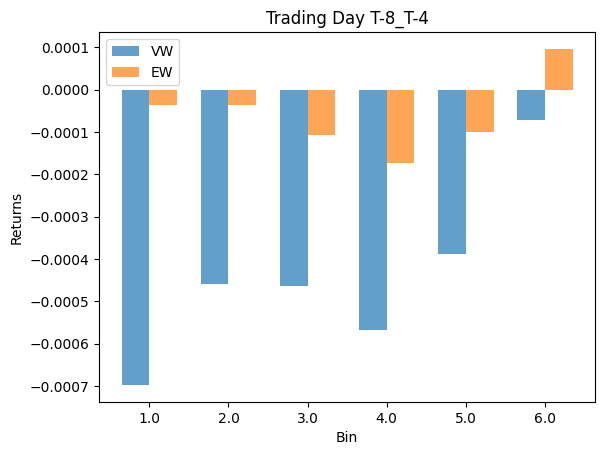

In [19]:
import numpy as np
import matplotlib.pyplot as plt

unique_period_label = bins['period_label'].unique()
num_days = len(unique_period_label)
width = 0.35  # Bar width

# Plot each trading day
for i, day in enumerate(unique_period_label, 1):
    plt.figure(figsize=(10, 6))  # Adjust the size as needed
    day_data = bins[bins['period_label'] == day]
    x = np.arange(len(day_data))  # Ensure x is a simple range of integers
    
    fig, ax = plt.subplots()
    
    # Plot the bars
    ax.bar(x - width/2, day_data['VW'], width, alpha=0.7, label='VW')
    ax.bar(x + width/2, day_data['EW'], width, alpha=0.7, label='EW')
    
    # Simplify the plot
    ax.set_xticks(x)
    ax.set_xticklabels(day_data['bin'].astype(str))  # Ensure proper x-tick labels
    ax.set_xlabel('Bin')
    ax.set_ylabel('Returns')
    ax.set_title(f'Trading Day {day}')
    ax.legend()
    
    plt.show()